In [ ]:


from PattRecClasses.GaussD import GaussD
from PattRecClasses.MarkovChain import MarkovChain
from PattRecClasses.HMM import HMM
from PattRecClasses.DiscreteD import DiscreteD

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/root
/content/drive/MyDrive/Teknisk fysik /ML-master/EQ2341 Pattern Recognition and Machine Learning/Assignment_3
Assignment3.ipynb  Figures/  gauss_logprob.py  PattRecClasses/  Songs/


In [ ]:
import numpy as np
'''
frIsequence = GetMusicFeatures(signal,fs)
or
frIsequence = GetMusicFeatures(signal,fs,winlength)

Method to calculate features for melody recognition

Usage:
First load a sound file using wavfile.read(...) or similar, then use this function
to extract pitch and energy contours of the melody in the sound. This
information can be used to compute a sequence of feature values or
vectors for melody recognition. Note that the pitch estimation is
unreliable (typically giving very high values) in silent segments, and
may not work at all for polyphonic sounds.

Input:
signal=      Vector containing sampled signal values (must be mono).
fs=          Sampling frequency of signal in Hz.
winlength=   Length of the analysis window in seconds (default 0.03).
             Square ("boxcar") analysis windows with 50% overlap are used.

Output:
frIsequence= Matrix containing pitch, correlation, and intensity estimates
             for use in creating features for melody recognition. Each column
             represents one frame in the analysis. Elements in the first
             row are pitch estimates in Hz (80--1100 Hz), the second row
             estimates the correlation coefficient (rho) between adjacent
             pitch periods, while the third row contains corresponding
             estimates of per-sample intensity.

References:
This method is based on a pitch estimator provided by Obada Alhaj Moussa.
'''

def GetMusicFeatures(signal, fs, winlength=0.03):

    # Wikipedia: "human voices are roughly in the range of 80 Hz to 1100 Hz"
    minpitch = 80
    maxpitch = 1100

    signal = np.real(np.double(signal)) # Make sure the signal is a real double

    signal = signal - np.mean(signal) # Remove DC, which can disturb intesities

    if fs <= 0:
        fs = samplerate # Replace illegal fs-values with the read sampling freq.

    # Compute the pitch periods in samples for the human voice range
    minlag = int( np.round(fs/maxpitch) )
    maxlag = int( np.round(fs/minpitch) )

    winlength = np.abs(winlength)
    winlength = np.round(winlength*fs) # Convert to number of samples
    winlength = max([ winlength+(winlength % 2), 2*minlag ]) # Make windows sufficiently long and an even sample number

    winstep = int( winlength/2 );
    nsteps = int( np.floor(len(signal)/winstep) ) - 1

    if (nsteps < 1):
        print(['ERROR: Signal too short. Use at least %s samples!'%(str(winlength))])
        return None

    frIsequence = np.zeros((3,nsteps)) # Initialize output variable to correct size

    pprdList = []
    for n in range(nsteps):
        # Cut out a segment of the signal starting at offset n*winlength sec
        window = signal[n*winstep : (n+1)*winstep]

        # Estimate the pitch (sampling frequency/pitch period), between-period
        # correlation coefficient, and intensity
        pprd, maxcorr = yin_pitch(window,minlag,maxlag)
        frIsequence[:,n] = [fs/pprd, maxcorr, np.linalg.norm(window/np.sqrt(len(window)))]
        pprdList.append(pprd)
        
    return frIsequence,pprdList

'''
Below is the pitch period estimation sub-routine.
The estimate is based on the autocorrelation function.
'''
def yin_pitch(signal,minlag=40,maxlag=200):

    N = len(signal)
    
    dif = np.zeros(maxlag - minlag)
    for idx in range(minlag, maxlag):
        seg1 = signal[idx : ]
        seg2 = signal[ : N - idx]

        # Estimate correlation ("dif") at lag idx
        dif[idx - minlag] = sum((seg1 - seg2)**2) / (N - idx)

    thresh = (max(dif) - min(dif)) * 0.1 + min(dif);

    
    # Locate the first minimum of dif, which is the first maximum of the
    # correlation; the corresponding lag is the pitch period.
    pprd = None
    idx = minlag
    while ( idx < maxlag ):
        if dif[idx - minlag] <= thresh:
            pprd = idx
            break

        idx = idx + 1

    # Allow the procedure to find the first minimum to roll over small "bumps"
    # in the autocorrelation functions, that are below than a 10% threshold.
    while idx < maxlag:
        if dif[idx - minlag] >= thresh:
            break

        if dif[idx - minlag] < dif[pprd - minlag]:
            pprd = idx

        idx = idx + 1

    seg1 = signal[pprd : ]
    seg2 = signal[: N - pprd]

    maxcorr = np.corrcoef(seg1,seg2)[0,1]
    
    return (pprd, maxcorr)

Assignment3.ipynb  Figures/  gauss_logprob.py  PattRecClasses/  Songs/


Text(0.5, 0, 't')

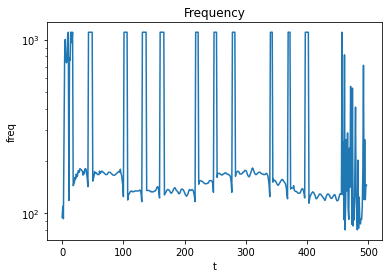

In [ ]:
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
%ls
fileName = "melody_1"
sr, mel1 = wavfile.read("Songs/"+fileName +  ".wav")

frIsequence,pprd =  GetMusicFeatures(mel1, sr, winlength=0.03)

#frIsequence[0][150:200] =  frIsequence[0][150:200] * 2

plt.yscale("log")
plt.plot(frIsequence[0,:])
plt.title("Frequency")
plt.ylabel("freq")
plt.xlabel("t")
#plt.savefig("Figures/freq_" + str(fileName) + ".png")

# plt.plot(frIsequence[1,:])
# plt.title("corr")
# plt.ylabel("r")
# plt.xlabel("t")


In [ ]:
def GetSemitones(frIsequence):
  f_log = np.log(frIsequence[0])
  f = frIsequence[0]
  mean = np.mean(f_log)
  stdev = np.std(f_log)
  f_max = mean + stdev
  f_min = mean - stdev

  log_I = np.log(frIsequence[2])
  r_thresh = np.mean(frIsequence[1])
  I_thresh = np.mean(log_I)

  r = frIsequence[1]

  noise = np.zeros(np.shape(f))
  print(noise.shape)
  for i in range(len(f)):
    if f_log[i]>f_max or f_log[i]<f_min or (r[i]<r_thresh and log_I[i]<I_thresh):
      noise[i] = 1
  #f_clean = f_log[np.where(noise==0)]
  f_clean = f[np.where(noise==0)]
  base_freq=np.min(f_clean)
  print(base_freq)
  semitones = 12*np.log2(f/base_freq) + 1

  for i in range(len(noise)):
    if noise[i] ==1:
      semitones[i] = np.random.rand(1)*0.5
  return semitones
semi1 = GetSemitones(frIsequence)

# plt.figure(1)
# plt.plot(semi1)



(498,)
114.24870466321244


In [27]:
'''
logP = gauss_logprob(pDs,x)
method to give the probability of a data sequence,
assumed to be drawn from given Gaussian Distribution(s).

Input:
pD=    GaussD object or array of GaussD objects
x=     row vector with data assumed to be drawn from a Gaussian Distribution

Result:
logP=  array with log-probability values for each element in x,
       for each given GaussD object
       size(p)== [length(pDs),size(x,2)], if pDs is one-dimensional vector
       size(p)== [size(pDs),size(x,2)], if pDs is multidim array
'''
def gauss_logprob(pDs, x):
    nObj = len(pDs) # Number of GaussD Objects
    nx = x.shape[1] # Number of observed vectors
    logP = np.zeros((nObj, nx))

    for i, pD in enumerate(pDs):
        dSize = pD.dataSize
        assert dSize == x.shape[0]

        z = np.dot(pD.covEigen, (x-np.matlib.repmat(pD.means, 1, nx)))

        z /= np.matlib.repmat(np.expand_dims(pD.stdevs, 1), 1, nx)

        logP[i, :] = -np.sum(z*z, axis=0)/2 
        logP[i, :] = logP[i, :] - sum(np.log(pD.stdevs)) - dSize*np.log(2*np.pi)/2

    return logP


## TESTCASES

#One-dimensional Gaussian
# g = []
# nsemitones=12
# for i in range(nsemitones):
#   g.append(GaussD( means=np.array( [i] ) , stdevs=np.array( [1.0] ) ))


g1 = GaussD( means=np.array( [0] ) , stdevs=np.array( [1.0] ) )
g2 = GaussD( means=np.array( [3] ) , stdevs=np.array( [2.0] ) )
g=[g1,g2]
x_Seq = np.array([[-0.2, 2.6, 1.3]])
logP = gauss_logprob(g,x_Seq)

print(np.exp(logP))
print(sum(sum(np.exp(logP))))

mc = MarkovChain( np.array( [[ 1, 0]] ), np.array( [ [ 0.9, 0.1], [ 0.1, 0.9 ] ] ) ) 
#mc = MarkovChain( np.array( [[ 1, 0]] ), np.array( [ [ 0.9, 0.1, 0], [ 0, 0.9, 0.1 ] ] ) ) 
# T = len(logP[0,:]) 
# N= len(logP) #num states
# print (T)
# print(N)

alpha = mc.forward(logP)

print(alpha)


# nsemitones=12
# means = np.array([np.arange(1,nsemitones + 1,dtype=float)]).transpose()
# cov = np.eye(nsemitones)
# # # Multi-dimensional Gaussian
# g1 = GaussD( means=means , cov=cov)
# # g1.rand(2)

# print([cov[0],cov[1]])

# gauss_logprob([g1], x_Seq)

# # Output: array([[-1.86376038, -2.74915905, -2.73003471]])

# # # Mismatched Parameters
# # g2 = GaussD( means=np.array( [[3.0], [0.0]] ) , cov=np.array( [[1.0, 0.5], [0.5, 1.0]] ) )
# # gauss_logprob([g2], g1.rand(3))

# # Output: array([[-11.66457869,  -3.23578104,  -4.46681203]])

0.9659684626499029
[[-0.93893853  3.63279514 -5.79425568]
 [-0.          0.15324282 -0.98903201]]


Your assignment report should include:

• Plots of the pitch and intensity profiles of the three recordings from
Songs.zip, two from the same melody, and one from another song.
MatLab code files for these plots should also be included. Make sure
that the scales and units are correct, and show which curve corresponds
to which recording.

• A clear specification of the design of your feature extractor, how it
integrates with the PattRecClasses output distributions, and how
your scheme addresses each of the requirements listed previously. It
must be clear that you understand your extractor and why it works.
• Working MatLab code for your feature extractor, either attached as
one or more separate m-files, or in a zip archive.

• Plots illustrating how your extracted features behave over time for the
three example files. It should be clear that two of the series are quite
similar, whereas the third is significantly different. Again, code for
generating these plots should be included.

• A plot that compares your feature output between a melody with a
transposed pitch track and the original recording, showing equivalence,
along with code for generating the plot.

• A discussion of aspects not captured by your feature extraction system, and possible cases where your feature extraction scheme may
work poorly. Is there any way a human can confuse the system, and
perform a melody or create a sound signal that we think sounds similar
to another performance, but where the features produced by your function are quite different between the two performances? What about
the opposite situation—can we create two recordings that sound like
two different songs altogether, but which actually generate very similar
feature sequences?